In [1]:
import pandas as pd
import numpy as np
import os
# from mootdx.quotes import Quotes
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_path = os.path.join('F:\stock', 'ETF')
# base_path = 'ETF'

In [3]:
def fun(x):
    if x > 0.2:
        return 1
    elif x < -0.2:
        return -1
    else:
        return 0
    
def fun2(x):
    if x > 0.06:
        return 1
    elif x < -0.06:
        return -1
    else:
        return 0

def fun3(x):
    if x > 0:
        return np.log(x+1)
    else:
        return -np.log(-x+1)
    
df_list = []
names = []
for path in os.listdir(base_path):
    names.append(path.split('.')[0])
    tmp_df = pd.read_csv(os.path.join(base_path, path))
    tmp_df['close_rate'] = tmp_df['close'] / tmp_df['pre_close'] - 1
    
    
    tmp_df['next_close'] = tmp_df['close'].shift(-1)
    tmp_df['buy_price'] = tmp_df['pre_close'].shift(-1)
    tmp_df['next_rate'] = tmp_df['close_rate'].shift(-1)

    tmp_df['high_rate'] = tmp_df['high'] / tmp_df['close'] - 1
    tmp_df['low_rate'] = tmp_df['low'] / tmp_df['close'] - 1
    tmp_df['close_rate2'] = tmp_df['close'] / tmp_df['open'] - 1
    
    tmp_df['close_rate_shift'] = tmp_df['close_rate'].shift(1)
    tmp_df['close_rate2_shift'] = tmp_df['close_rate2'].shift(1)
    tmp_df['vol_shift'] = tmp_df['vol'].shift(1) / tmp_df['vol'] - 1
    tmp_df['vol_shift'] = tmp_df['vol_shift'].apply(fun)
    tmp_df['close_kind'] = tmp_df['close_rate'].apply(fun2)
    tmp_df['vol_kind'] = tmp_df['vol_shift'] * tmp_df['close_kind']
    
    tmp_df['signal'] = 1 * tmp_df['high_rate'] + 3 * tmp_df['low_rate'] + 2 * tmp_df['close_rate2'] + 1 * tmp_df['close_rate'] + \
                  + 0.5 * tmp_df['vol_kind'] - 0.5 * tmp_df['close_rate_shift']
    
    tmp_df['signal'] = tmp_df['signal'].apply(lambda x: fun3(x))
    tmp_df.dropna(inplace=True)
    df_list.append(tmp_df)
#     break

In [4]:
df = pd.concat(df_list)

tmp_df = pd.DataFrame()
tmp_df['trade_date'] = sorted(df['trade_date'].unique())
# index_df = pd.read_csv('000001.SH.csv')
index_df = pd.read_csv('F:\\stock\\IndexData\\000001.SH.csv')
tmp_df = tmp_df.merge(index_df[['trade_date', 'close']], on='trade_date', how='left')
tmp_df['rate2'] = tmp_df['close'] / tmp_df['close'][0]

df.dropna(inplace=True)

In [5]:
cors = []
for i in range(len(df_list)):
    a = np.array(df_list[i]['signal'])[:-1]
    b = np.array(df_list[i]['next_rate'])[:-1]
    cor = np.corrcoef(a, b)
    cors.append(cor[0][1])
print(cors)
print(np.mean(cors))

[0.22325045135024565, 0.12793769834848664, -0.018085137525583574, 0.09696044564219664, 0.10037860338231455, 0.1614555339493735, 0.12141267890814707, 0.0458041669157205, 0.113305251883312, 0.16815465228876722, 0.1465649226172446, -0.049856441138083664, 0.11611508043392885, 0.03196409816050801, 0.10404456519050599, 0.08357450756261532, 0.10016525240128034, -0.06430126434854588, 0.1452818058568443]
0.09232246694101463


In [14]:
init_money = 100000
market_value = init_money
left_money = init_money
service_rate = 0.00005
values = [init_money]
# values = [init_money]
hold_num = dict(zip(df['ts_code'].unique(), np.zeros(df['ts_code'].nunique())))
next_closes = dict(zip(df['ts_code'].unique(), np.zeros(df['ts_code'].nunique())))
market_values_ = []
k = 0
thresh_hold = -0.005
flag = True
for i,g in tqdm(df.groupby('trade_date')):
    k+=1

    g = g.reset_index(drop=True)
    signal = g['signal'].values

    idx = np.where(signal<thresh_hold)[0]
    signal[idx] = thresh_hold
    tmp = signal - min(signal)
    
#     if np.sum(tmp!=0) < len(tmp) * 0.2:
#         max_cangwei = 0.3
#     elif np.sum(tmp!=0) < len(tmp) * 0.3:
#         max_cangwei = 0.45
#     elif np.sum(tmp!=0) < len(tmp) * 0.4:
#         max_cangwei = 0.6
#     else:
#         max_cangwei = 1
    max_cangwei = 1

    idx = np.argsort(tmp)[::-1]
    for i in range(5, len(idx)):
        tmp[idx[i]] = 0
    cangwei = tmp / (tmp.sum()+1e-6) * max_cangwei
    
    cangwei = np.round(cangwei, 2)

    nums = []
    left_money = market_value
    
    for j in range(len(g)):
        # -100 给手续费留一些空间
        money = (market_value-100) * cangwei[j]
        num = money / g['buy_price'][j] // 100
        nums.append(num)
        left_money = left_money - num * 100 * (g['buy_price'][j]) * (1+service_rate)
        hold_num[g['ts_code'][j]] = num
        next_closes[g['ts_code'][j]] = g['next_close'][j]

    # 计算市值
    market_value = 0
    for key in hold_num:
        market_value = market_value + hold_num[key] * 100 * (next_closes[key]) * (1-service_rate)
        hold_num[key] = 0
    market_value += left_money
    market_values_.append(market_value)
#     break

100%|██████████| 2190/2190 [00:01<00:00, 1265.88it/s]


In [15]:
market_value

1469644.703559924

In [16]:
tmp_df['market_value'] = market_values_
tmp_df['rate1'] = tmp_df['market_value'] / init_money

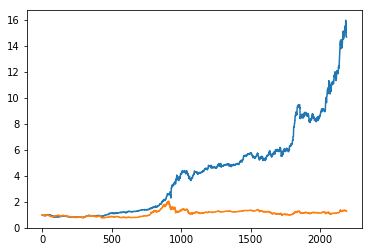

In [17]:
plt.figure()
plt.plot(tmp_df['rate1'])
plt.plot(tmp_df['rate2'])
plt.show()

In [18]:
tmp_df

,trade_date,close,rate2,market_value,rate1
0,20110908,2498.9430,1.000000,1.000000e+05,1.000000
1,20110909,2497.7530,0.999524,9.900997e+04,0.990100
2,20110913,2471.3050,0.988940,9.900997e+04,0.990100
3,20110914,2484.8270,0.994351,9.900997e+04,0.990100
4,20110915,2479.0550,0.992041,9.918088e+04,0.991809
...,...,...,...,...,...
2185,20200904,3355.3666,1.342714,1.505294e+06,15.052944
2186,20200907,3292.5907,1.317593,1.529259e+06,15.292589
2187,20200908,3316.4170,1.327128,1.472041e+06,14.720413
2188,20200909,3254.6279,1.302402,1.472041e+06,14.720413


In [19]:
def max_return(arr):
    max_r = 0
    max_ = arr[0]
    for i in range(len(arr)):
        tmp = arr[i] #/ max_
        if tmp > max_:
            max_ = tmp
        if 1 - tmp / max_ > max_r:
            max_r = 1 - tmp / max_
#             print(i, tmp, max_, max_r)
    return max_r
# print(max_return(tmp_df['rate1']))
print(max_return(tmp_df['rate1'].values))

0.21494448358744223


In [20]:
last_price = tmp_df['rate1'][0]
last_price2 = tmp_df['rate2'][0]
for i in range(9):
    start = 20110906 + 10000 * i
    end = 20110906 + 10000 * (i+1)
    tmp_df2 = tmp_df[(tmp_df['trade_date']>start)&(tmp_df['trade_date']<=end)]
    profit = tmp_df2['rate1'].values[-1] / last_price - 1
    profit2 = tmp_df2['rate2'].values[-1] / last_price2 - 1
    max_return_ = max_return(tmp_df2['rate1'].values)
    last_price = tmp_df2['rate1'].values[-1]
    last_price2 = tmp_df2['rate2'].values[-1]
    info = str(start) + '-' + str(end) + ', ETF策略收益率为: ' + str(np.round(profit,2))  + ', 最大回撤为：' + str(max_return_)
    info = info + ' , 上证收益率: ' + str(np.round(profit2, 2)) 
    print(info)

20110906-20120906, ETF策略收益率为: -0.13, 最大回撤为：0.21494448358744223 , 上证收益率: -0.18
20120906-20130906, ETF策略收益率为: 0.28, 最大回撤为：0.1354201737977152 , 上证收益率: 0.04
20130906-20140906, ETF策略收益率为: 0.27, 最大回撤为：0.062074718672202045 , 上证收益率: 0.09
20140906-20150906, ETF策略收益率为: 1.67, 最大回撤为：0.1697080188392509 , 上证收益率: 0.36
20150906-20160906, ETF策略收益率为: 0.28, 最大回撤为：0.17456565954460335 , 上证收益率: -0.02
20160906-20170906, ETF策略收益率为: 0.15, 最大回撤为：0.059449082301959 , 上证收益率: 0.1
20170906-20180906, ETF策略收益率为: 0.08, 最大回撤为：0.10395695046324571 , 上证收益率: -0.2
20180906-20190906, ETF策略收益率为: 0.48, 最大回撤为：0.14480686372186025 , 上证收益率: 0.11
20190906-20200906, ETF策略收益率为: 0.71, 最大回撤为：0.09036187778709026 , 上证收益率: 0.12
